In this script, we calculate f_k  (% contribution of each size bin k to the toal DAOD) for a given dust PSD referring to Eq. (7) in Song et al. 2022


Based on Eq.(7), we need to know three variables to calculate f_k.

(1), Qe at 532nm as a function of geometric diameter: Qe(D) 

(2), Projected area as a function of geometric diameter: A(D) 

(3), Dust Particle Size Distribution: dN/dD

The first two variables are provided by Song et al. 2022 in 'Qe532nm_ProjectedArea.txt'.

Therefore, users can calculate f_k for any user-defined dust PSD.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
from netCDF4 import Dataset
import scipy
from scipy import stats

In [6]:
#----------
# Read Qe and Projected Area (A) data from the data we provided.
# We provide Qe and A for two dust shapes (i.e., sphere and spheroid) and three dust RI (i.e., MaxRI, MeanRI, MinRI) in 'Qe532nm_ProjectedArea.txt'. 
# (Details see Section 2.2 in Song et al. 2022)
#----------

# Note, this cell is to read 'Qe532nm_ProjectedArea.txt' file. 
# User can change the data_dir path to acess 'Qe532nm_ProjectedArea.txt' in user's google drive.
data_dir = '../Data/' 
data = np.loadtxt(data_dir+'Qe532nm_ProjectedArea.txt', skiprows=1)

r_eqv = data[:,0] #'r_eqv' represents radius for sphere, and represents volume equivalent radius for spheroid (i.e., geometric radius)

# Read Projected Area and Qext for Spherical dust.
A_sphere = data[:,1] # 'A_sphere' is the projected area of spherical particles with radius=r_eqv
Qe_sphere_maxri = data[:,3] # 'Qe_sphere_maxri' is the extinction efficiency (Qext at 532nm) for MaxRI-Sphere dust model
Qe_sphere_meanri = data[:,4] # 'Qe_sphere_meanri' is the extinction efficiency (Qext at 532nm) for MeanRI-Sphere dust model
Qe_sphere_minri = data[:,5] # 'Qe_sphere_minri' is the extinction efficiency (Qext at 532nm) for MinRI-Sphere dust model

# Read Projected Area and Qext for Spheroidal dust with Shape distribution described in Dubovik et al. 2006.
A_spheroid = data[:,2] # 'A_spheroid' is the shape-averaged projected area of spheroidal particles with r_eqv
Qe_spheroid_maxri = data[:,6] # 'Qe_spheroid_maxri' is the shape-averaged extinction efficiency (Qext at 532nm) for MaxRI-Spheroid dust model
Qe_spheroid_meanri = data[:,7] # 'Qe_spheroid_meanri' is the shape-averaged extinction efficiency (Qext at 532nm) for MeanRI-Spheroid dust model
Qe_spheroid_minri = data[:,7] # 'Qe_spheroid_minri' is the shape-averaged extinction efficiency (Qext at 532nm) for MinRI-Spheroid dust model


In [7]:
#----------
# Dust Particle Size Distribution (PSD)
# As an example, we use the global averaged dust PSD in the atmosphere from Kok et al. 2017 
# This cell is to obtain dust PSD in the form of dN/dD based on the method introduced in Kok et al. 2017.
#----------

D=r_eqv*2 # 'D' is volume equivalent diameter or geometric diameter

#dV/dlnD at emission
omega_s=2.1
D_M=1.52
lamda=20.5

a=np.log(D/D_M) / (np.sqrt(2)*np.log(omega_s))
b=scipy.special.erf(a)
dvdlnd_emit = (D)*(1+b)*np.exp(-(D/lamda)**3)

Cv =np.trapz(dvdlnd_emit/D,D)
dvdlnd_emit_norm = dvdlnd_emit/Cv

#dust lifetime
D_dep = 4.6 # unit: days
T_0 = 12.5 # unit: days

T_D = T_0*np.exp(-D/D_dep)

#global mean dV/dlnD in the atmosphere
dvdlnd_atm = dvdlnd_emit_norm*T_D
#normalize dV/dlnD
Cv =np.trapz(dvdlnd_atm/D,D)
dvdlnd_atm_norm = dvdlnd_atm/Cv

#Convert dV/dlnD to dN/dD
dNdD = 6/(np.pi*D**4)*dvdlnd_atm_norm

In [8]:
#----------
# Define dust size bin. 
# There are 10 size bins ranging from D=0.1 micro to D=100 micro
#----------

Nbin=10
d_bin_edge = np.logspace(-1,2,Nbin+1) #diameter bin edge
d_bin_center = (d_bin_edge[:-1]+d_bin_edge[1:])/2
d_bin_length = d_bin_edge[1:]-d_bin_edge[:-1]
print(d_bin_edge)

[  0.1          0.19952623   0.39810717   0.79432823   1.58489319
   3.16227766   6.30957344  12.58925412  25.11886432  50.11872336
 100.        ]


In [9]:
#----------
# For the given dust PSD above (dN/dD), we calculate f_k for the 6 dust models (i.e., two dust shapes and three dust RI) respectively
# '_sphere_maxri' indicates Sphere-MaxRI dust
# '_sphere_meanri' indicates Sphere-MeanRI dust
# '_sphere_minri' indicates Sphere-MinRI dust
# '_spheroid_maxri' indicates Spheroid-MaxRI dust
# '_spheroid_meanri' indicates Spheroid-MeanRI dust
# '_spheroid_minri' indicates Spheroid-MinRI dust
#----------

faod_sphere_maxri = np.zeros(Nbin)
faod_sphere_meanri = np.zeros(Nbin)
faod_sphere_minri = np.zeros(Nbin)
faod_spheroid_maxri = np.zeros(Nbin)
faod_spheroid_meanri = np.zeros(Nbin)
faod_spheroid_minri = np.zeros(Nbin)

for ibin in range(Nbin):
    #Mask the diameter (D) within each size range
    if ibin==0:
        d_low = d_bin_edge[ibin]
    else:
        d_low = D[d_mask][-1]
    d_up = d_bin_edge[ibin+1]
    d_mask = (D >=d_low) & (D <= d_up)

    #Follow Eq.(7) in Song et al. 2022 to calculate f_k for 6 dust models
    faod_sphere_maxri_up = np.trapz(Qe_sphere_maxri[d_mask]*A_sphere[d_mask]*dNdD[d_mask],D[d_mask])
    faod_sphere_maxri_down = np.trapz(Qe_sphere_maxri*A_sphere*dNdD,D)
    faod_sphere_maxri[ibin] = faod_sphere_maxri_up/faod_sphere_maxri_down
    
    faod_sphere_meanri_up = np.trapz(Qe_sphere_meanri[d_mask]*A_sphere[d_mask]*dNdD[d_mask],D[d_mask])
    faod_sphere_meanri_down = np.trapz(Qe_sphere_meanri*A_sphere*dNdD,D)
    faod_sphere_meanri[ibin] = faod_sphere_meanri_up/faod_sphere_meanri_down
    
    faod_sphere_minri_up = np.trapz(Qe_sphere_minri[d_mask]*A_sphere[d_mask]*dNdD[d_mask],D[d_mask])
    faod_sphere_minri_down = np.trapz(Qe_sphere_minri*A_sphere*dNdD,D)
    faod_sphere_minri[ibin] = faod_sphere_minri_up/faod_sphere_minri_down
    
    faod_spheroid_maxri_up = np.trapz(Qe_spheroid_maxri[d_mask]*A_spheroid[d_mask]*dNdD[d_mask],D[d_mask])
    faod_spheroid_maxri_down = np.trapz(Qe_spheroid_maxri*A_spheroid*dNdD,D)
    faod_spheroid_maxri[ibin] = faod_spheroid_maxri_up/faod_spheroid_maxri_down
    
    faod_spheroid_meanri_up = np.trapz(Qe_spheroid_meanri[d_mask]*A_spheroid[d_mask]*dNdD[d_mask],D[d_mask])
    faod_spheroid_meanri_down = np.trapz(Qe_spheroid_meanri*A_spheroid*dNdD,D)
    faod_spheroid_meanri[ibin] = faod_spheroid_meanri_up/faod_spheroid_meanri_down

    faod_spheroid_minri_up = np.trapz(Qe_spheroid_minri[d_mask]*A_spheroid[d_mask]*dNdD[d_mask],D[d_mask])
    faod_spheroid_minri_down = np.trapz(Qe_spheroid_minri*A_spheroid*dNdD,D)
    faod_spheroid_minri[ibin] = faod_spheroid_minri_up/faod_spheroid_minri_down


In [10]:
#----------
#Sanity Check: the sum of f_k over 10 size bins should be 1
#----------
print(faod_sphere_maxri.sum())
print(faod_sphere_minri.sum())
print(faod_spheroid_maxri.sum())
print(faod_spheroid_minri.sum())

1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002


In [11]:
print(faod_sphere_meanri)

[6.24812894e-05 6.43301441e-03 1.04343514e-01 2.09756744e-01
 3.31424431e-01 2.42719828e-01 9.43038253e-02 1.09038367e-02
 5.23236508e-05 1.58516456e-13]


In [12]:
#----------
#Save f_k to 'Faod_kok17PSD_2Shape_3RI.txt', which will be used to calculate dust DRE as shown in Eq.(6)
#----------
faod = np.vstack((faod_sphere_maxri,faod_sphere_meanri,faod_sphere_minri,faod_spheroid_maxri,faod_spheroid_meanri,faod_spheroid_minri)).T
print(faod.shape)
np.savetxt('Faod_kok17PSD_2Shape_3RI.txt',faod,fmt='%20.3e',\
           header='{:20s}{:20s}{:20s}{:20s}{:20s}{:20s}'.format('faod_sphere_maxri','faod_sphere_meanri','faod_sphere_minri',\
                                                                'faod_spheroid_maxri','faod_spheroid_meanri','faod_spheroid_minri'))

# Download 'Faod_kok17PSD_2Shape_3RI.txt' to user's local file system.
#from google.colab import files
#files.download('Faod_kok17PSD_2Shape_3RI.txt')

(10, 6)


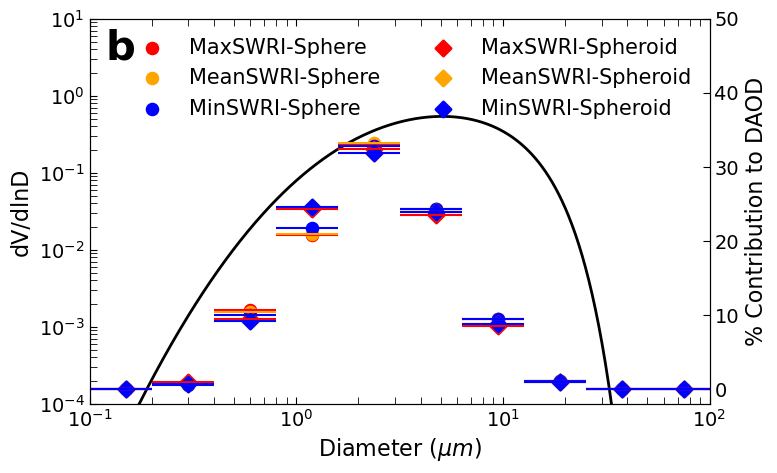

In [9]:
#----------
# Plot dust PSD and f_k for 6 dust models
#----------
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.plot(r_eqv*2,dvdlnd_atm_norm,lw=2,c='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.1,100)
ax1.set_ylim(1e-4,10)
ax1.set_ylabel('dV/dlnD',fontsize=16)
ax1.set_xlabel('Diameter ($\mu m$)',fontsize=16)
ax1.text(0.12,3,'b',fontsize=30,fontweight='bold')
ax2=ax1.twinx()
ax2.scatter(d_bin_center,faod_sphere_maxri*1e2,marker='o',lw=2,s=60,c='r',label='MaxSWRI-Sphere')
ax2.errorbar(d_bin_center,faod_sphere_maxri*1e2,xerr=d_bin_length/2,fmt='none',c='r')
ax2.scatter(d_bin_center,faod_sphere_meanri*1e2,marker='o',lw=2,s=60,c='orange',label='MeanSWRI-Sphere')
ax2.errorbar(d_bin_center,faod_sphere_meanri*1e2,xerr=d_bin_length/2,fmt='none',c='orange')
ax2.scatter(d_bin_center,faod_sphere_minri*1e2,marker='o',lw=2,s=60,c='b',label='MinSWRI-Sphere')
ax2.errorbar(d_bin_center,faod_sphere_minri*1e2,xerr=d_bin_length/2,fmt='none',c='b')
ax2.scatter(d_bin_center,faod_spheroid_maxri*1e2,marker='D',lw=2,s=60,c='r',label='MaxSWRI-Spheroid')
ax2.errorbar(d_bin_center,faod_spheroid_maxri*1e2,xerr=d_bin_length/2,fmt='none',c='r')
ax2.scatter(d_bin_center,faod_spheroid_meanri*1e2,marker='D',lw=2,s=60,c='orange',label='MeanSWRI-Spheroid')
ax2.errorbar(d_bin_center,faod_spheroid_meanri*1e2,xerr=d_bin_length/2,fmt='none',c='orange')
ax2.scatter(d_bin_center,faod_spheroid_minri*1e2,marker='D',lw=2,s=60,c='b',label='MinSWRI-Spheroid')
ax2.errorbar(d_bin_center,faod_spheroid_minri*1e2,xerr=d_bin_length/2,fmt='none',c='b')
ax2.set_ylim(-2,50)
ax2.set_ylabel('% Contribution to DAOD',fontsize=16,c='k')
ax2.legend(loc='upper right',fontsize=15,frameon=0,ncol=2)
ax1.tick_params(which='both',direction='in',length=5,labelsize=14,top=True)
ax2.tick_params(which='both',direction='in',length=5,labelsize=14)

<ErrorbarContainer object of 3 artists>

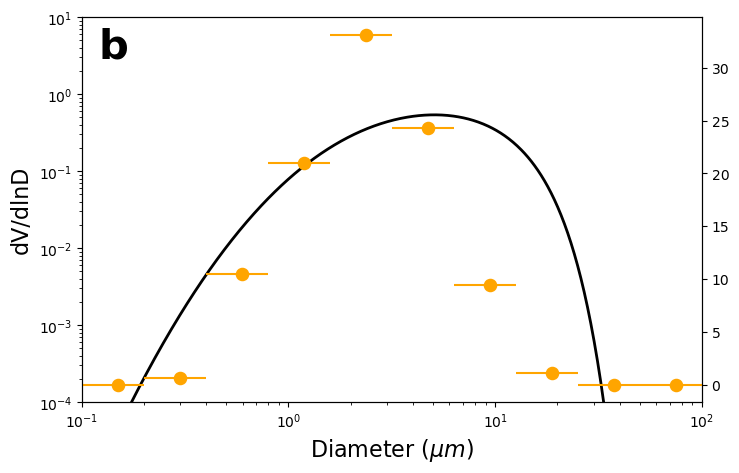

In [10]:
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.plot(r_eqv*2,dvdlnd_atm_norm,lw=2,c='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.1,100)
ax1.set_ylim(1e-4,10)
ax1.set_ylabel('dV/dlnD',fontsize=16)
ax1.set_xlabel('Diameter ($\mu m$)',fontsize=16)
ax1.text(0.12,3,'b',fontsize=30,fontweight='bold')
ax2=ax1.twinx()
ax2.scatter(d_bin_center,faod_sphere_meanri*1e2,marker='o',lw=2,s=60,c='orange',label='MeanSWRI-Sphere')
ax2.errorbar(d_bin_center,faod_sphere_meanri*1e2,xerr=d_bin_length/2,fmt='none',c='orange')

In [13]:
print('faod_sphere_meanri',faod_sphere_meanri)

faod_sphere_meanri [6.24812894e-05 6.43301441e-03 1.04343514e-01 2.09756744e-01
 3.31424431e-01 2.42719828e-01 9.43038253e-02 1.09038367e-02
 5.23236508e-05 1.58516456e-13]


In [14]:
print('d_bin_center',d_bin_center)
# In um SW wavelengths

d_bin_center [ 0.14976312  0.2988167   0.5962177   1.18961071  2.37358543  4.73592555
  9.44941378 18.85405922 37.61879384 75.05936168]
